In [3]:
# Standard library imports
import os
import json
import sys
import re
import concurrent.futures
from typing import List, Dict, Any, Tuple, TypedDict, Annotated, Optional

# Third-party imports
import boto3
import fitz
import requests
from bs4 import BeautifulSoup
from opensearchpy import OpenSearch, RequestsHttpConnection
from pydantic import BaseModel, Field, ValidationError
from IPython.display import Image

# LangChain core imports
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langchain_core.tools import tool
from langchain.schema import BaseRetriever, Document

# LangGraph imports
from langgraph.graph import StateGraph, add_messages, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# LangChain AWS imports
from langchain_aws import ChatBedrockConverse, BedrockEmbeddings

# LangChain experimental imports
from langchain_experimental.tools.python.tool import PythonAstREPLTool

# LangChain community imports
from langchain_community.tools.tavily_search import TavilySearchResults

# Operator imports
from operator import itemgetter


In [4]:
def visualize(graph):
    display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
    )

In [5]:
bedrock_client = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-east-1'  # replace with your region
)
llm = ChatBedrockConverse(
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    client=bedrock_client,
    temperature=0.7,
    max_tokens=2000
)

In [6]:
class ChildState(TypedDict):
    name: str  # 부모 그래프와 공유되는 상태 키
    family_name: str


# 서브그래프의 첫 번째 노드, family_name 키에 초기값 설정
def subgraph_node_1(state: ChildState):
    return {"family_name": "Lee"}


# 서브그래프의 두 번째 노드, 서브그래프 전용 family_name 키와 공유 name 키를 결합하여 새로운 상태 생성
def subgraph_node_2(state: ChildState):
    # 서브그래프 내부에서만 사용 가능한 family_name 키와 공유 상태 키 name를 사용하여 업데이트 수행
    return {"name": f'{state["name"]} {state["family_name"]}'}

subgraph_builder = StateGraph(ChildState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


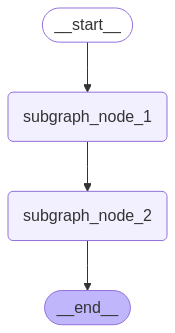

In [7]:
visualize(subgraph)

In [8]:
class ParentState(TypedDict):
    name: str
    company: str


# 부모 그래프의 첫 번째 노드, name 키의 값을 수정하여 새로운 상태 생성
def node_1(state: ParentState):
    return {"name": f'My name is {state["name"]}'}


# 부모 그래프 구조 정의 및 서브그래프를 포함한 노드 간 연결 관계 설정
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
# 컴파일된 서브그래프를 부모 그래프의 노드로 추가
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()

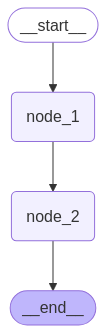

In [10]:
visualize(graph)

In [11]:
for chunk in graph.stream({"name": "Teddy"}):
    print(chunk)


{'node_1': {'name': 'My name is Teddy'}}
{'node_2': {'name': 'My name is Teddy Lee'}}


In [12]:
for chunk in graph.stream({"name": "Teddy"}, subgraphs=True):
    print(chunk)


((), {'node_1': {'name': 'My name is Teddy'}})
(('node_2:af21abbb-3fc4-139c-e7fd-eecefebf8137',), {'subgraph_node_1': {'family_name': 'Lee'}})
(('node_2:af21abbb-3fc4-139c-e7fd-eecefebf8137',), {'subgraph_node_2': {'name': 'My name is Teddy Lee'}})
((), {'node_2': {'name': 'My name is Teddy Lee'}})


In [13]:
# 서브그래프의 상태 타입 정의 (부모 그래프와 키를 공유하지 않음)
class ChildState(TypedDict):
    # 부모 그래프와 공유되지 않는 키들
    name: str


# 서브그래프의 첫 번째 노드: name 키에 초기값 설정
def subgraph_node_1(state: ChildState):
    return {"name": "Teddy " + state["name"]}


# 서브그래프의 두 번째 노드: name 값 그대로 반환
def subgraph_node_2(state: ChildState):
    return {"name": f'My name is {state["name"]}'}


# 서브그래프 빌더 초기화 및 노드 연결 구성
subgraph_builder = StateGraph(ChildState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


# 부모 그래프의 상태 타입 정의
class ParentState(TypedDict):
    family_name: str
    full_name: str


# 부모 그래프의 첫 번째 노드: family_name 값 그대로 반환
def node_1(state: ParentState):
    return {"family_name": state["family_name"]}


# 부모 그래프의 두 번째 노드: 서브그래프와 상태 변환 및 결과 처리
def node_2(state: ParentState):
    # 부모 상태를 서브그래프 상태로 변환
    response = subgraph.invoke({"name": state["family_name"]})
    # 서브그래프 응답을 부모 상태로 변환
    return {"full_name": response["name"]}


# 부모 그래프 빌더 초기화 및 노드 연결 구성
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)

# 컴파일된 서브그래프 대신 서브그래프를 호출하는 node_2 함수 사용
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()


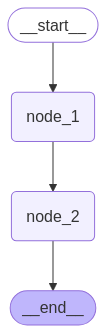

In [14]:
visualize(graph)

In [15]:
for chunk in graph.stream({"family_name": "Lee"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'family_name': 'Lee'}})
(('node_2:3ea1f695-7d45-2a2f-cf2f-13f945de3a6d',), {'subgraph_node_1': {'name': 'Teddy Lee'}})
(('node_2:3ea1f695-7d45-2a2f-cf2f-13f945de3a6d',), {'subgraph_node_2': {'name': 'My name is Teddy Lee'}})
((), {'node_2': {'full_name': 'My name is Teddy Lee'}})
